# Simulate PTA with PTA-replicator and Enterprise

In [1]:
from pta_replicator_main.pta_replicator.simulate import load_from_directories
from pta_replicator_main.pta_replicator.simulate import make_ideal
from pta_replicator_main.pta_replicator.white_noise import add_measurement_noise
from pta_replicator_main.pta_replicator.red_noise import add_red_noise, add_gwb
from pta_replicator_main.pta_replicator.deterministic import add_cgw

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import selections
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals.utils import hd_orf
from enterprise.signals import utils
from enterprise_extensions.deterministic import cw_block_circ

import pickle
import dill
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from random import sample, seed

import params_injected
from pulsar_phase import get_psr_phase

%load_ext autoreload
%autoreload 2

## Simulate pulsars

In [2]:
pardir = 'partim/par'
timdir = 'partim/tim'
num_psrs = params_injected.num_psrs
# psrs = load_from_directories(pardir, timdir, num_psrs=num_psrs)
psrs_full = load_from_directories(pardir, timdir, num_psrs=50)
seed(0)
psrs = sample(psrs_full, k=num_psrs)

2025-08-09 22:05:34.557 | DEBUG    | pint.toa:__init__:1358 - No pulse number flags found in the TOAs
2025-08-09 22:05:34.558 | DEBUG    | pint.toa:apply_clock_corrections:2200 - Applying clock corrections (include_gps = True, include_bipm = True)
2025-08-09 22:05:34.566 | INFO     | pint.observatory:gps_correction:210 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-09 22:05:34.566 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2025-08-09 22:05:34.569 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-08-09 22:05:34.572 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:456 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/Users/aidengundersen/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2025-08-09 22:05:34.590 | INFO     | pint.

In [3]:
# store injected parameters
x_inj = {}

# add signals and noise
psr_phases = np.zeros(num_psrs)
for ii, psr in enumerate(psrs):

    ## make ideal
    make_ideal(psr)

    # add efacs
    ## if you use flags, the flags and efac and equad values all need to have the same number of elements
    add_measurement_noise(psr,
                          efac=params_injected.efac_inj, 
                          seed=params_injected.efac_seed + ii)

    ## add red noise
    if params_injected.rn_model:
        add_red_noise(psr,
                      log10_amplitude=params_injected.RN_logamps_inj[ii],
                      spectral_index=params_injected.RN_gammas_inj[ii],
                      components=params_injected.num_modes,
                      seed=params_injected.RN_seed + ii)
        x_inj[f'{psr.name}_red_noise_log10_A'] = params_injected.RN_logamps_inj[ii]
        x_inj[f'{psr.name}_red_noise_gamma'] = params_injected.RN_gammas_inj[ii]
    
    ## add continuous wave
    if params_injected.cw_model:
        ent_psr = psr.to_enterprise()
        psr_dist = ent_psr.pdist[0]
        psr_phase = get_psr_phase(params_injected.CW_params_inj, ent_psr.pos, psr_dist)
        psr_phases[ii] = psr_phase
        psr_params = np.array([psr_dist, psr_phase])
        add_cgw(psr, params_injected.CW_params_inj, psr_params, ent_psr.toas, ent_psr.pos)
        x_inj[f'{psr.name}_cw_p_dist'] = psr_dist
        x_inj[f'{psr.name}_cw_p_phase'] = psr_phase 

    print(ii, psr.name)

# add common CW parameters
if params_injected.cw_model:
    x_inj['cw_cosinc'] = params_injected.cosinc_inj
    x_inj['cw_costheta'] = params_injected.costheta_inj
    x_inj['cw_log10_Mc'] = params_injected.log10_mc_inj
    x_inj['cw_log10_dL'] = params_injected.log10_dist_inj
    x_inj['cw_log10_fgw'] = params_injected.log10_fgw_inj
    x_inj['cw_phase0'] = params_injected.phase0_inj
    x_inj['cw_phi'] = params_injected.gwphi_inj
    x_inj['cw_psi'] = params_injected.psi_inj

2025-08-09 22:05:44.535 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-09 22:05:44.536 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-09 22:05:44.536 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-09 22:05:44.537 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-09 22:05:44.552 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-09 22:05:44.552 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-09 22:05:44.553 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-09 22:05:44.553 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-09 22:05:44.553 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

0 J1312+0051


2025-08-09 22:05:45.176 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409705e+09  1.34555717e+11  5.83294451e+10] m
2025-08-09 22:05:45.176 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.178 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.178 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.179 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.180 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.181 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.182 | INFO     | pint.sol

1 J1909-3744


2025-08-09 22:05:45.668 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409706e+09  1.34555717e+11  5.83294451e+10] m
2025-08-09 22:05:45.669 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.670 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.671 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.672 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.673 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.673 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:45.674 | INFO     | pint.sol

2 J1455-3330


2025-08-09 22:05:46.228 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-09 22:05:46.229 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-09 22:05:46.229 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-09 22:05:46.229 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-09 22:05:46.244 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-09 22:05:46.244 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-09 22:05:46.244 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-09 22:05:46.245 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-09 22:05:46.245 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

3 B1953+29


2025-08-09 22:05:46.774 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-09 22:05:46.775 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-09 22:05:46.775 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-09 22:05:46.776 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-09 22:05:46.792 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-09 22:05:46.792 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-09 22:05:46.793 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-09 22:05:46.793 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-09 22:05:46.794 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

4 J0709+0458


2025-08-09 22:05:47.203 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409706e+09  1.34555717e+11  5.83294451e+10] m
2025-08-09 22:05:47.203 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:47.204 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:47.205 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:47.206 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:47.207 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:47.208 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:47.209 | INFO     | pint.sol

5 J1705-1903


2025-08-09 22:05:47.702 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:47.703 | DEBUG    | pint.toa:compute_posvels:2417 - Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos obs_jupiter_pos obs_saturn_pos obs_venus_pos obs_uranus_pos obs_neptune_pos obs_earth_pos
2025-08-09 22:05:47.764 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-09 22:05:47.764 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-09 22:05:47.765 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-09 22:05:47.765 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-09 22:05:47.780 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-09 22:05:47.780 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Remov

6 J1643-1224


2025-08-09 22:05:48.256 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-09 22:05:48.256 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-09 22:05:48.257 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-09 22:05:48.257 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-09 22:05:48.272 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-09 22:05:48.272 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-09 22:05:48.273 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-09 22:05:48.273 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-09 22:05:48.274 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

7 J1453+1902


2025-08-09 22:05:48.677 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:48.678 | DEBUG    | pint.toa:compute_posvels:2417 - Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos obs_jupiter_pos obs_saturn_pos obs_venus_pos obs_uranus_pos obs_neptune_pos obs_earth_pos
2025-08-09 22:05:48.739 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-09 22:05:48.740 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-09 22:05:48.740 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-09 22:05:48.741 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-09 22:05:48.756 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-09 22:05:48.756 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Remov

8 J1012+5307


2025-08-09 22:05:49.156 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409706e+09  1.34555717e+11  5.83294451e+10] m
2025-08-09 22:05:49.156 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:49.158 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:49.158 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:49.159 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:49.160 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:49.161 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:05:49.162 | INFO     | pint.sol

9 J1640+2224


In [4]:
if params_injected.gwb_model:
        add_gwb(psrs,
                log10_amplitude=params_injected.GWB_logamp_inj,
                spectral_index=params_injected.GWB_gamma_inj,
                seed=params_injected.GWB_seed)
        x_inj['log10_A_gw'] = params_injected.GWB_logamp_inj
        x_inj['gamma_gw'] = params_injected.GWB_gamma_inj

In [5]:
# fit timing model
for psr in psrs:
    print(psr.name)
    psr.fit()

2025-08-09 22:05:49.457 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1312+0051


2025-08-09 22:05:50.282 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0005357847285737405
2025-08-09 22:05:50.643 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1909-3744


2025-08-09 22:05:51.435 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.00017403584984376774
2025-08-09 22:05:51.486 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1455-3330


2025-08-09 22:05:52.278 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.005055402628803662
2025-08-09 22:05:52.333 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


B1953+29


2025-08-09 22:05:53.112 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.003481612457758132
2025-08-09 22:05:53.161 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0709+0458


2025-08-09 22:05:53.936 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.005765402257543073
2025-08-09 22:05:54.288 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1705-1903


2025-08-09 22:05:55.071 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0008984486396620417
2025-08-09 22:05:55.431 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1643-1224


2025-08-09 22:05:56.213 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0009154130041970632
2025-08-09 22:05:56.570 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1453+1902


2025-08-09 22:05:57.426 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.00020388132971738138
2025-08-09 22:05:57.479 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1012+5307


2025-08-09 22:05:58.291 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.008040328649208561
2025-08-09 22:05:58.672 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1640+2224


2025-08-09 22:05:59.471 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.000859843418387532


J1312+0051


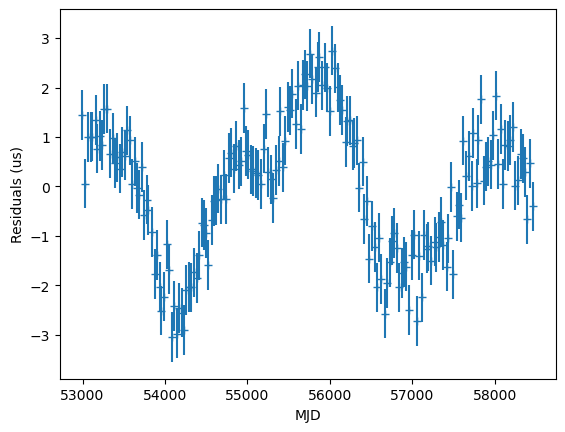

J1909-3744


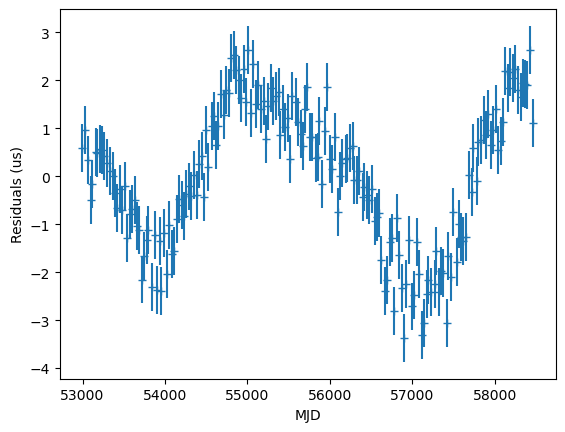

J1455-3330


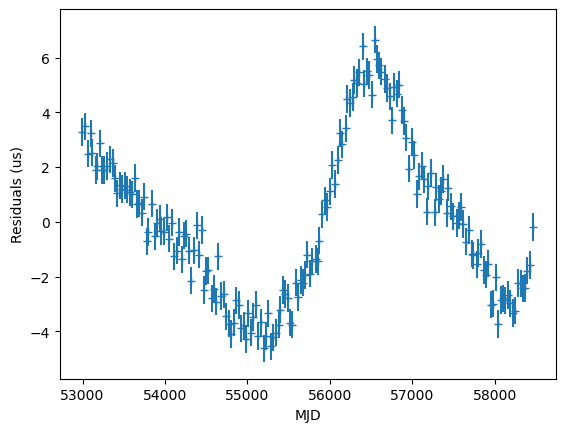

B1953+29


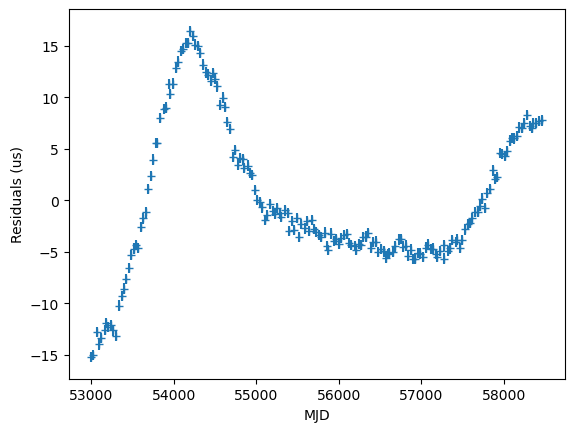

J0709+0458


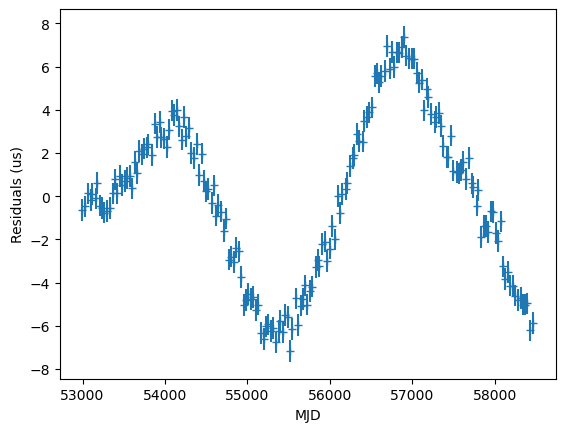

J1705-1903


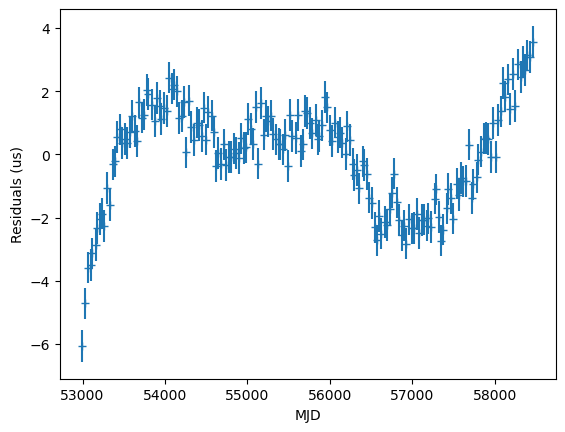

J1643-1224


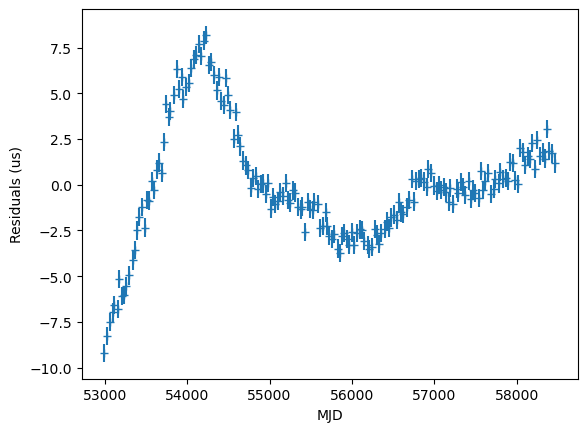

J1453+1902


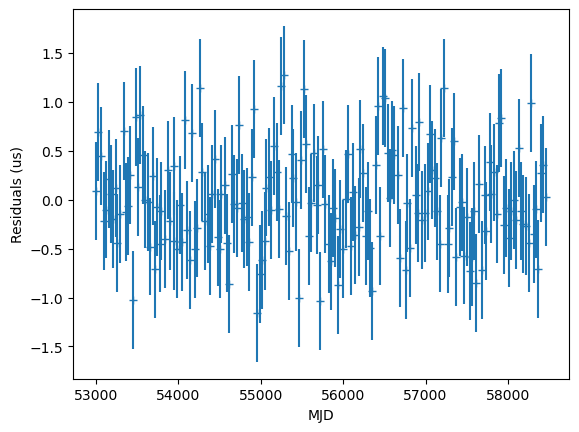

J1012+5307


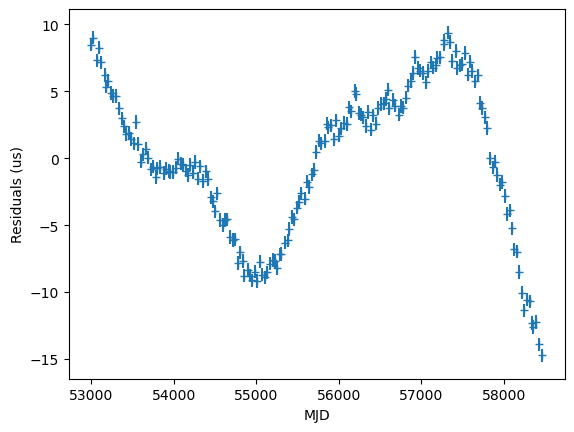

J1640+2224


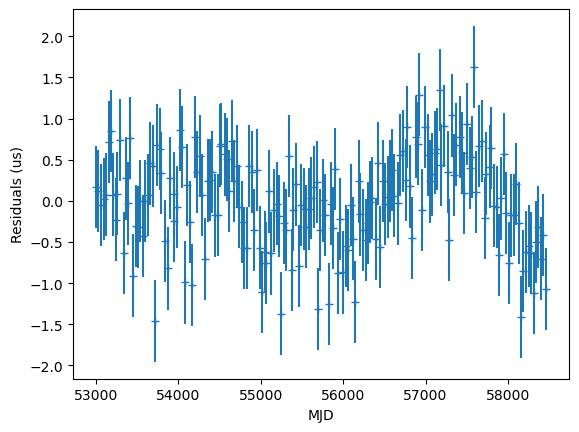

In [6]:
for psr in psrs:
    print(psr.name)
    plt.errorbar(
        psr.toas.get_mjds(),
        psr.residuals.time_resids.to_value("us"),
        psr.residuals.get_data_error().to_value("us"),
        marker="+",
        ls="",
    )
    plt.xlabel("MJD")
    plt.ylabel("Residuals (us)")
    plt.show()

In [7]:
# convert to enterprise type pulsars
ent_psrs = []
for psr in psrs:
    ent_psrs.append(psr.to_enterprise())

2025-08-09 22:06:00.920 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:06:00.939 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-08-09 22:06:00.940 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-09 22:06:01.417 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:06:01.436 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-08-09 22:06:01.437 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-09 22:06:01.896 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-09 22:06:01.915 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-08-09 22:06:01.915 | DEBUG    | pint.models.astrometry:ssb_

In [8]:
# save Enterprise pulsar objects
with open('data/enterprise_pulsars.pkl', 'wb') as f:
    pickle.dump(ent_psrs, f)

## Make PTA

In [9]:
# use built in backend selection
backend = selections.Selection(selections.by_backend)

# EFAC parameter
if params_injected.wn_model:
    efac_param = parameter.Uniform(0.5, 3.0)
else:
    efac_param = params_injected.efac_inj

# make white noise
wn = white_signals.MeasurementNoise(efac=efac_param,
                                    log10_t2equad=-1000, 
                                    selection=backend)

In [10]:
# red noise
if params_injected.rn_model:
    logamp_param = parameter.Uniform(-18., -11.)
    gamma_param = parameter.Uniform(1., 7.)

    # get power law in prior
    powlaw = gp_priors.powerlaw(log10_A=logamp_param, gamma=gamma_param)

    # make red noise
    rn = gp_signals.FourierBasisGP(spectrum=powlaw, components=params_injected.num_modes)

In [11]:
# GWB
if params_injected.gwb_model:
    log10_A_gw = parameter.Uniform(-18., -11.)('log10_A_gw')
    gamma_gw = parameter.Uniform(1., 7.)('gamma_gw')
    cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
    gw = gp_signals.FourierBasisCommonGP(spectrum=cpl, orf=hd_orf(),
                                         components=params_injected.num_modes, name='gw')

In [12]:
# make CW signal
if params_injected.cw_model:
    cw = cw_block_circ(dist_prior='log-uniform', psrTerm=True)

In [13]:
# make timing model
tm = gp_signals.TimingModel(use_svd=True)

In [14]:
# make model and PTA object
model = tm + wn
if params_injected.rn_model:
    model += rn
if params_injected.gwb_model:
    model += gw
if params_injected.cw_model:
    model += cw
    
pta = signal_base.PTA([model(psr) for psr in ent_psrs])

In [15]:
# save PTA object
with open('data/pta.pkl', 'wb') as f:
    dill.dump(pta, f)

print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1312+0051_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1312+0051_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J1312+0051_red_noise                     FourierBasisGP                 2                   

params:
J1312+0051_red_noise_log10_A:Uniform(pmin=-18.0, pmax=-11.0)                              
J1312+0051_red_noise_gamma:Uniform(pmin=1.0, pmax=7.0)                                    
__________________________________________________________________________________________
J1909-3744_linear_timing_model_svd       TimingModel                    0                   

params:
_______

In [16]:
# save data
Fs = np.array([basis[:, 8:] for basis in pta.get_basis()])
Ms = np.array([ent_psr.Mmat for ent_psr in ent_psrs])
Ns = np.array([np.diag(ent_psr.toaerrs**2.) for ent_psr in ent_psrs])
toas = np.array([ent_psr.toas for ent_psr in ent_psrs])
residuals = np.array([ent_psr.residuals for ent_psr in ent_psrs])
psr_pos = np.array([ent_psr.pos for ent_psr in ent_psrs])
psr_names = np.array([ent_psr.name for ent_psr in ent_psrs])
psr_dists = np.array([[psr.pdist[0], psr.pdist[1]] for psr in ent_psrs]).T

# save data in dictionary
data_dict = {}
data_dict['Fs'] = Fs
data_dict['Ms'] = Ms
data_dict['Ns'] = Ns
data_dict['toas'] = toas
data_dict['residuals'] = residuals
data_dict['psr_pos'] = psr_pos
data_dict['psr_names'] = psr_names
data_dict['psr_dists'] = psr_dists
data_dict['psr_phases'] = psr_phases
data_dict['x_inj'] = x_inj
np.savez_compressed('data/data_dict.npz', **data_dict)

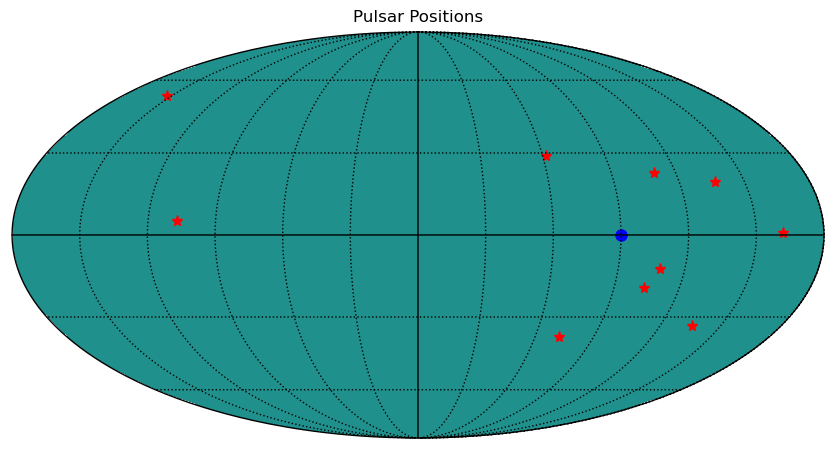

In [17]:
# plot pulsar positions
theta_psr = np.arccos(psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.arctan2(psr_pos[:, 1], psr_pos[:, 0])  # atan2(y, x)
phi_psr = np.mod(phi_psr, 2 * np.pi)


# Convert to HEALPix map
nside = 64
npix = hp.nside2npix(nside)

# Plot
hp.mollview(np.zeros(hp.nside2npix(64)), title="Pulsar Positions", cbar=False)
hp.projplot(theta_psr, phi_psr, 'r*', markersize=8)
hp.projplot(params_injected.gwtheta_inj, params_injected.gwphi_inj, 'bo', markersize=8)
hp.graticule()
plt.show()